<a href="https://colab.research.google.com/github/jamesnatoli/Trains/blob/main/Amtrak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, make a wrapper for the dictionaries that are returned from the api calls

In [45]:
import matplotlib.pyplot as plt
import datetime
from zoneinfo import ZoneInfo
import numpy as np
import requests
import re

# Object wrapper for dictionary
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

    def __repr__(self):
        return '<%s>' % str('\n '.join('%s : %s' % (k, repr(v)) for (k, v) in self.__dict__.items()))

    def __getattr__( self, attr):
        value = self.__dict__.get(attr)
        if not value:
            print(f'Warning: \'Struct\' object has no attribute \'{attr}\', returning -1')
            return -1
        else:
            return value

Next, we'll create a class to handle the api calls for us

In [46]:
class Amtrak:
    def __init__( self):
        self.api = 'https://api-v3.amtraker.com/v3/'

    def fetchAllTrains( self):
        data = requests.get( self.api + 'trains').json()
        return [ Struct(**v[0]) for k, v in data.items()]

    def fetchTrain( self, trainID):
        data = requests.get( self.api + 'trains/' + str(trainID)).json()
        return Struct(**data[str(trainID)][0])

    def fetchAllStations( self):
        data = requests.get( self.api + 'stations').json()
        return [ Struct(**v) for k, v in data.items()]

    def fetchStation( self, stationID):
        data = requests.get( self.api + 'stations/' + stationID).json()
        return Struct(**data[stationID])

    def fetchTrainPerformance( self, plot=False):
        count = 0
        total = 0
        allLateness = []
        latestTime = -1
        latestTrain = Struct()
        for train in self.fetchAllTrains():
            if train.trainState != 'Active': continue
            total+=1
            howLate = float()
            txt = train.trainTimely
            if 'Late' not in train.trainTimely: continue
            count+=1
            match = re.search(r"^(\d*) Hours?, (\d*) Minutes? Late$", txt)
            if match:
                howLate = (float(match.group(1)) * 60) + float(match.group(2))
            else:
                match = re.search(r"(\d*) Minutes? Late$", txt)
                if not match:
                    print("NO MATCH")
                    exit(0)
                else:
                    howLate = float(match.group(1))
            allLateness.append(howLate)

            if howLate > latestTime:
                latestTime = howLate
                latestTrain = train

        if plot:
            binlow = 0
            binhigh = round(max(allLateness), -1) + 10
            plt.hist( allLateness, bins=int(binhigh/10), range=[binlow, binhigh])
            plt.ylabel(r'$N_{trains}$', loc='top')
            plt.xlabel('Minutes')
            plt.xticks( np.arange(binlow, binhigh, step=30))
            plt.title('Amtrak Late Trains', fontweight='bold', loc='left')
            plt.title(datetime.datetime.now(tz=ZoneInfo("America/New_York")).strftime("%Y-%m-%d %H:%M:%S (%Z)"), loc="right")
            plt.show()

        print(f'{count} / {total} trains are late')
        print(f'{latestTrain.routeName} from {latestTrain.origName} towards {latestTrain.destName} is {latestTrain.trainTimely}')
        return latestTrain, latestTrain.trainTimely

    def fetchFastestTrain( self, plot=False):
        fastestTrain = Struct()
        fastestVelocity = -1
        allVelocities = []

        for train in self.fetchAllTrains():
            if train.trainState != 'Active': continue
            howFast = train.velocity
            allVelocities.append( howFast)
            if howFast > fastestVelocity:
                fastestVelocity = howFast
                fastestTrain = train

        if plot:
            binlow = 0
            binhigh = round(max(allVelocities), -1) + 10
            plt.hist( allVelocities, bins=int(binhigh/10), range=[binlow, binhigh])
            plt.ylabel(r'$N_{trains}$', loc='top')
            plt.xlabel('Velocity (mph)')
            # plt.xticks( np.arange(binlow, binhigh, step=25))
            plt.title('Velocity of Amtrak Trains', fontweight='bold', loc='left')
            plt.title(datetime.datetime.now(tz=ZoneInfo("America/New_York")).strftime("%Y-%m-%d %H:%M:%S (%Z)"), loc="right")
            plt.show()


        print(f'{fastestTrain.routeName} from {fastestTrain.origName} towards {fastestTrain.destName} is travelling {round(fastestVelocity, 2)} mph')
        return fastestTrain, fastestTrain.velocity

Now we can use the class to get some interesting information about the Amtrak trains. Any additional functions we can add to the Amtrak class

First, let's get the performance of the active trains and make a histogram of them. This only shows trains that are late.

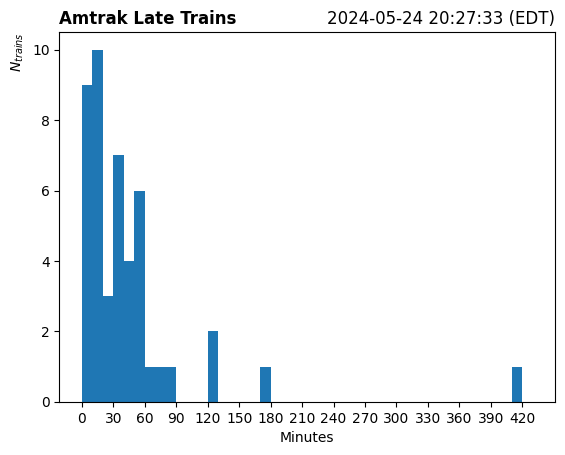

46 / 118 trains are late
Silver Star from New York Penn towards Miami is 6 Hours, 58 Minutes Late


In [47]:
# create object
amtrak = Amtrak()

# default is plot=False
latestTrain, howLate = amtrak.fetchTrainPerformance(plot=True)

Now let's see where that very late train is

In [48]:
for station in latestTrain.stations:
  if station['status'] != 'Departed':
    print(f"Next Station: {station['name']}")
    break

Next Station: Lakeland


We can also plot the distribution of velocities, and of course get the current fastest train

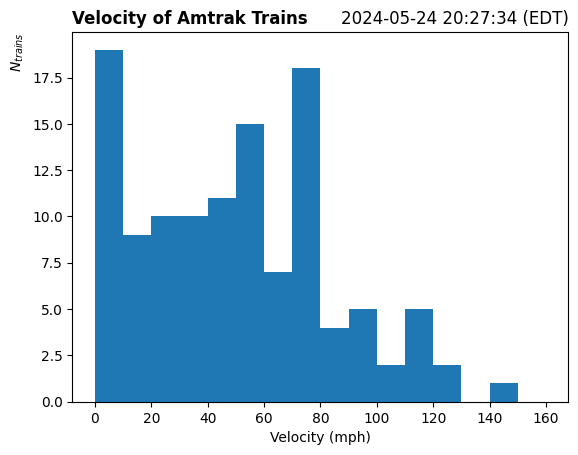

Acela from Washington Union towards Boston South is travelling 147.1 mph


In [49]:
fastestTrain, howFast = amtrak.fetchFastestTrain( plot=True)

Note the peak before 80 mph, this can be explained by the fact that many Amtrak trains run on sections of track with a speed limit of 79 mph

Now let's see where that speedy train is going that fast

In [51]:
idx = 0

stations = fastestTrain.stations
station = stations[idx]

while station['status'] == 'Departed':
    idx+=1
    station = stations[idx]

nextStation = station
prevStation = stations[idx-1]

print(f"{fastestTrain.routeName} is travelling {round(howFast, 2)} mph {fastestTrain.heading} between {prevStation['name']} and {nextStation['name']}")

Acela is travelling 147.1 mph N between Providence and Westwood-Route 128
